In [1]:
!pip install transformers
!pip install git+https://github.com/millawell/bias-ml-dh.git#subdirectory=material/notebooks/bias_ml_dh_utils
!pip install --upgrade tqdm

     |████████████████████████████████| 501kB 9.7MB/s 
     |████████████████████████████████| 1.0MB 62.6MB/s 
     |████████████████████████████████| 3.7MB 61.9MB/s 
     |████████████████████████████████| 870kB 59.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=9e796c22cc9022df2c05cc06ba5109f33774408f315c672c5571f25e71483d4d
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
  Cloning https://github.com/millawell/bias-ml-dh.git to /tmp/pip-req-build-kva9cmpj
  Running command git clone -q https://github.com/millawell/bias-ml-dh.git /tmp/pip-req-build-kva9cmpj
  Created wheel for bias-ml-dh-utils: filename=bias_ml_dh_utils-0.1-cp36-none-any.whl size=3080 sha256=71a14ce3fd03b2f01fc0bfb3e29fb32092cb9866012b7fa08cf63f0cf3af5f9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7li9huf/wheels/54/60/10/c502c7f524d0053a13237a26e797b9fb57f76b4488edc4d6

In [2]:
from collections import Counter
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sbn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

from transformers import glue_processors as processors
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features

from transformers.data.processors import DataProcessor, InputExample, InputFeatures

import bias_ml_dh_utils as utils

class classification_dataset(DataProcessor):
    """Adopted from the Processor for the SST-2 data set (GLUE version)."""

    def __init__(self, df, guid_prefix):

        input_ = df["text"]
        labels = df["label"]
        self.unique_labels = list(set(labels))
        guid=0
        self.collection = []

        for x,y in zip(input_, labels):
            self.collection.append(
                InputExample(
                    guid="{}-{}".format(guid_prefix, guid),
                    text_a=x,
                    text_b=None,
                    label=y
                )
            )
            guid += 1

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence"].numpy().decode("utf-8"),
            None,
            str(tensor_dict["label"].numpy()),
        )

    def get_examples(self):
        """See base class."""
        return self.collection

    def get_labels(self):
        """See base class."""
        return self.unique_labels


def fine_tune(model_name, df_train, df_eval, output_mode, max_len=40, task_name="unknown", device="cuda:0"):

    device = torch.device(device)
    train_dataset = classification_dataset(df_train, "train")
    eval_dataset = classification_dataset(df_eval, "eval")

    output_mode = "classification"
    label_list = train_dataset.get_labels()
    num_labels = len(label_list)

    config_class, model_class, tokenizer_class = BertConfig, BertForSequenceClassification, BertTokenizer
    
    config = config_class.from_pretrained(
        model_name,
        num_labels=num_labels,
        finetuning_task=task_name,
        id2label={i:k for i,k in enumerate(label_list)},
        label2id={k:i for i,k in enumerate(label_list)},
        max_length=max_len,
        output_attentions=True
    )

    tokenizer = tokenizer_class.from_pretrained(
        model_name,
        do_lower_case=False
    )

    model = model_class.from_pretrained(
        model_name,
        config=config
    )

    model.to(device)

    train_dataset = load_and_cache_examples(train_dataset.get_examples(), tokenizer, label_list, output_mode, max_len)

    eval_dataset = load_and_cache_examples(eval_dataset.get_examples(), tokenizer, label_list, output_mode, max_len)
    
    global_step, tr_loss = train(device, model, train_dataset, eval_dataset)

    print(" global_step = %s, average loss = %s", global_step, tr_loss)
    result = evaluate(device, model, eval_dataset)
    print("evaluation accuracy: {}".format(result))

    return model, tokenizer


def train(device, model, train_dataset, eval_dataset):

    cnt = Counter(s[-1].item() for s in train_dataset)
    classes = sorted(list(cnt.keys()))
    num_train_samples_per_class = torch.tensor([cnt[c] for c in classes]).float()

    weights = 1.0/num_train_samples_per_class
    labels = torch.tensor([d[3] for d in train_dataset])
    
    weights = weights[torch.tensor(labels)]

    train_batch_size = 8
    sampler = WeightedRandomSampler(weights, len(weights))
    train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=train_batch_size)

    num_train_epochs = 5
    max_steps = -1

    weight_decay = 0.0
    learning_rate = 5e-5
    adam_epsilon = 1e-8
    warmup_steps = 0
    max_grad_norm = 1.0

    t_total = len(train_dataloader) * num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
    )

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(num_train_epochs), desc="Epoch",
    )

    for _ in train_iterator:

        eval_result = evaluate(device, model, eval_dataset)
        print("eval_result: {}".format(eval_result))

        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):

            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            loss.backward()

            tr_loss += loss.item()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            global_step += 1


            if max_steps > 0 and global_step > max_steps:
                epoch_iterator.close()
                break
        if max_steps > 0 and global_step > max_steps:
            train_iterator.close()
            break

    return global_step, tr_loss / global_step


def load_and_cache_examples(examples, tokenizer, label_list, output_mode, max_seq_length):

    features = convert_examples_to_features(
        examples,
        tokenizer,
        label_list=label_list,
        max_length=max_seq_length,
        output_mode=output_mode,
        pad_on_left=False,
        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
        pad_token_segment_id=0,
    )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

def evaluate(device, model, eval_dataset):

    eval_batch_size = 8

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
    
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3],
            }
            outputs = model(**inputs)

            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    print(classification_report(out_label_ids, preds))
    return (preds == out_label_ids).mean()

def predict(model, predict_dataset, device="cuda:0"):

    pred_batch_size = 8

    pred_sampler = SequentialSampler(predict_dataset)
    pred_dataloader = DataLoader(predict_dataset, sampler=pred_sampler, batch_size=pred_batch_size)
    
    preds = []
    out_label_ids = None

    for batch in tqdm(pred_dataloader, desc="Prediction"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3],
            }
            outputs = model(**inputs)
            preds += outputs[1].argmax(axis=1).detach().tolist()

    return preds

def predict_single_sample(input_text, tokenizer, model, device, layer, label_list, output_mode, max_len, cols=True):

    examples = []
    tweet_ids = []
    guid = 0
    
    for text in input_text:

        examples.append(
            InputExample(guid="pred-{}".format(guid), text_a=text, text_b=None, label="neutral")
        )
        guid += 1
    
    features = convert_examples_to_features(
        examples,
        tokenizer,
        label_list=label_list,
        max_length=max_len,
        output_mode=output_mode,
        pad_on_left=False,
        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
        pad_token_segment_id=0,
    )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    pred_batch_size = 8

    pred_sampler = SequentialSampler(dataset)
    pred_dataloader = DataLoader(dataset, sampler=pred_sampler, batch_size=pred_batch_size)
    
    preds = []
    out_label_ids = None
    for batch in tqdm(pred_dataloader, desc="Prediction"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3],
            }
            outputs = model(**inputs)
            preds += outputs[1].argmax(axis=1).detach().tolist()

    print("Layer: ",layer)
    attention = outputs[2][layer][0][0]
    fig, ax = plt.subplots(figsize=(2,10))         # Sample figsize in inches
    tokens = tokenizer.convert_ids_to_tokens(batch[0][0])
    cutoff = tokens.index("[PAD]")
    tokens = np.asarray(tokens).reshape((40,1))[:cutoff]

    if cols:
      sbn.heatmap(attention[0,:cutoff,None].cpu(),annot=tokens,fmt='',ax=ax)
    else:
      sbn.heatmap(attention[:cutoff,0,None].cpu(),annot=tokens,fmt='',ax=ax)
    plt.show()
    
    return preds

In [3]:
path_to_senti_data = utils.download_dataset("twitter_sentiment_german")
df = pd.read_pickle(path_to_senti_data)

df = df[["full_text", "label"]]
df.columns = ["text", "label"]

df_train, df_eval = train_test_split(df)
label_list = sorted(list(set(df_train["label"].tolist())))
model_name =  "dbmdz/bert-base-german-cased"
output_mode = "classification"
max_len = 40

model, tokenizer = fine_tune(
    model_name,
    df_train,
    df_eval,
    output_mode=output_mode,
    max_len=max_len,
    task_name="sentiment_analyis"
)

path_to_thueringen = utils.download_dataset("twitter_thueringen_small")

thueringen_tweets = []

with open(path_to_thueringen) as fin:
    for row in fin:
        tweet = json.loads(row)
        thueringen_tweets.append({
            "id": tweet["id_str"],
            "text": tweet["full_text"],
            "label": label_list[0]
        })
df_pred = pd.DataFrame(thueringen_tweets)
tweet_ids = df_pred["id"].tolist()

predict_dataset = classification_dataset(df_pred, "predict")

predict_dataset = load_and_cache_examples(
    predict_dataset.get_examples(),
    tokenizer,
    label_list,
    output_mode,
    max_len
)

predictions = predict(model, predict_dataset)
df = pd.DataFrame.from_dict({
    "tweet_ids" : tweet_ids,
    "sentiments": list(map(lambda x: label_list[x],  predictions))
})

password for extracting zip: ··········


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


              precision    recall  f1-score   support

           0       0.21      0.49      0.30       372
           1       0.65      0.43      0.52      1054
           2       0.09      0.04      0.05       237

    accuracy                           0.39      1663
   macro avg       0.32      0.32      0.29      1663
weighted avg       0.47      0.39      0.40      1663

eval_result: 0.3878532772098617


Epoch:  20%|██        | 1/5 [01:08<04:34, 68.72s/it]


              precision    recall  f1-score   support

           0       0.76      0.56      0.64       372
           1       0.81      0.87      0.84      1054
           2       0.48      0.54      0.51       237

    accuracy                           0.75      1663
   macro avg       0.68      0.65      0.66      1663
weighted avg       0.75      0.75      0.75      1663

eval_result: 0.7504509921828022


Epoch:  40%|████      | 2/5 [02:18<03:27, 69.11s/it]


              precision    recall  f1-score   support

           0       0.59      0.79      0.67       372
           1       0.85      0.81      0.83      1054
           2       0.60      0.41      0.48       237

    accuracy                           0.75      1663
   macro avg       0.68      0.67      0.66      1663
weighted avg       0.76      0.75      0.75      1663

eval_result: 0.7492483463619964


Epoch:  60%|██████    | 3/5 [03:29<02:19, 69.62s/it]


              precision    recall  f1-score   support

           0       0.64      0.77      0.70       372
           1       0.85      0.84      0.84      1054
           2       0.58      0.41      0.48       237

    accuracy                           0.76      1663
   macro avg       0.69      0.67      0.67      1663
weighted avg       0.76      0.76      0.76      1663

eval_result: 0.761876127480457


Epoch:  80%|████████  | 4/5 [04:40<01:09, 69.92s/it]


              precision    recall  f1-score   support

           0       0.64      0.77      0.70       372
           1       0.85      0.83      0.84      1054
           2       0.59      0.47      0.52       237

    accuracy                           0.77      1663
   macro avg       0.69      0.69      0.69      1663
weighted avg       0.77      0.77      0.76      1663

eval_result: 0.7654840649428744


Epoch: 100%|██████████| 5/5 [05:50<00:00, 70.13s/it]


 global_step = %s, average loss = %s 3120 0.3205627785995603



              precision    recall  f1-score   support

           0       0.69      0.75      0.72       372
           1       0.83      0.86      0.85      1054
           2       0.60      0.41      0.49       237

    accuracy                           0.77      1663
   macro avg       0.71      0.68      0.68      1663
weighted avg       0.77      0.77      0.77      1663

evaluation accuracy: 0.7739025856885148
password for extracting zip: ··········



Layer:  0


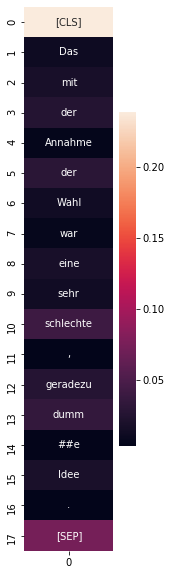

[2]

In [4]:
input_text = "Das mit der Annahme der Wahl war eine sehr schlechte, geradezu dumme Idee."
predict_single_sample([input_text], tokenizer, model, "cuda:0", 0, label_list=label_list, output_mode=output_mode, max_len=max_len, cols=False)